# Library Preparation

In [1]:
import os
import tarfile
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/drive')
my_path = '/drive/MyDrive/Colab/Project/'

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [2]:
titanic = pd.read_csv('https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/titanic/train.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# Preprocessing Data

In [4]:
# Seperate features and label / class

y = titanic.Survived
x = titanic.drop(['Survived'], axis=1).copy()
x.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# Drop unused columns

x.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
x.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [6]:
# Fill the missing values in feature age

x.Age.replace(np.nan, x.Age.median(), inplace=True)
x.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [7]:
# One-hot encode for categorical features

x = pd.get_dummies(x, columns=['Pclass', 'Sex', 'Embarked'])
x.head()

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,22.0,1,0,7.2500,0,0,1,0,1,0,0,1
1,38.0,1,0,71.2833,1,0,0,1,0,1,0,0
2,26.0,0,0,7.9250,0,0,1,1,0,0,0,1
3,35.0,1,0,53.1000,1,0,0,1,0,0,0,1
4,35.0,0,0,8.0500,0,0,1,0,1,0,0,1


In [8]:
# Scale the features with standard scaler

scl_features = x.columns[:4]
x[scl_features] = (x[scl_features] - x[scl_features].mean()) / x[scl_features].std()
x.head()

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,-0.565418,0.432550,-0.473408,-0.502163,0,0,1,0,1,0,0,1
1,0.663488,0.432550,-0.473408,0.786404,1,0,0,1,0,1,0,0
2,-0.258192,-0.474279,-0.473408,-0.488580,0,0,1,1,0,0,0,1
3,0.433068,0.432550,-0.473408,0.420494,1,0,0,1,0,0,0,1
4,0.433068,-0.474279,-0.473408,-0.486064,0,0,1,0,1,0,0,1


# Build Models

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

import time
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import make_scorer, accuracy_score as acc, f1_score as f1

### Automation Prep.

Builds some functions to my own automation pipeline.

In [10]:
def running_time(start, end, argumen='Total running time:'):
  '''
  This function is to calculate time (in second) between two events.
  '''
  total_time = end - start
  total_time_s = total_time
  print('{} {} s'.format(argumen, total_time))
  return total_time_s


def run_with_cv(model, x, y):
  '''
  Functions to perform cross validation and retrieve 
  the required metrics in my the automation pipeline.
  '''
  res = cross_validate(model, x, y, scoring=['accuracy', 'f1'], cv=5)
  return res['fit_time'].mean(), res['test_accuracy'].mean(), res['test_f1'].mean()


def run_with_gridSearchCV(model, param_grid, scoring, x, y):
  '''
  Functions to perform grid search cv. Of course, this function 
  takes the required metrics, but also takes the best estimator 
  to be used in the feature selection section at the end.
  '''
  grid_search = GridSearchCV(model, param_grid, cv=5, scoring=scoring, 
                             refit='Accuracy', return_train_score=True,
                             verbose=1)  
  # fit to data
  grid_search.fit(x,y)  
  # get best score (by acc) index
  idx = grid_search.best_index_
  # just to see the best params
  best_param = grid_search.best_params_
  # get the best acc, f1, time, and estimator
  mean_time = grid_search.cv_results_['mean_fit_time'][idx]
  mean_acc = grid_search.cv_results_['mean_test_Accuracy'][idx]
  mean_f1 = grid_search.cv_results_['mean_test_F1-Score'][idx]
  best_est = grid_search.best_estimator_
  return mean_time, mean_acc, mean_f1, best_est, best_param


def run_with_feature_selection(model, scoring, x, y, direction='backward'):
  '''
  Functions to perform feature selection based on estimator 
  which obtained from the results of the grid search, then 
  tested with cross validation. this function takes the 
  required metrics and the best features.
  '''  
  sfs = SequentialFeatureSelector(model,
                                  direction=direction, 
                                  n_features_to_select=len(x.columns)//2,
                                  cv=5)
  # fit to x
  sfs.fit(x,y)
  # get important features
  best_features = x.columns.values[sfs.get_support()]
  print(best_features)
  # transform x to test to the model
  x_best_features = sfs.transform(x)
  time_fs, acc_fs, f1_fs = run_with_cv(model, x_best_features, y)  
  return time_fs, acc_fs, f1_fs, x_best_features

### Model & Parameter Setting

In [11]:
scoring = {'Accuracy':make_scorer(acc), 'F1-Score':make_scorer(f1)}

list_model_name = ['Logistic Regression', 'KNN', 'Decision Tree',
                   'Random Forest', 'XGBoost', 'SVM', 'Neural Network']

list_model = [LogisticRegression(), KNeighborsClassifier(), DecisionTreeClassifier(),
              RandomForestClassifier(), XGBClassifier(), SVC(), MLPClassifier()]

rs = 42

list_param_grid = [                   
                   [{# LR's param grid
                     'solver':['liblinear','lbfgs'],
                     'C':[i/1000 for i in range(1,100)], 
                     'tol':[1e-3,1e-4,1e-5], 
                     'random_state':[rs],
                   }], 
                   
                   [{# KNN's param grid
                     'weights':['uniform','distance'],
                     'n_neighbors':list(range(1,20)),                      
                     'p':[1,2],
                     'algorithm':['auto','ball_tree',
                                  'kd_tree','brute'],
                   }], 
                   
                   [{# DT's param grid
                     'criterion':['gini','entropy'], 
                     'max_depth':list(range(2,11)),
                     'max_features':list(range(4,len(x.columns))),                     
                     'min_samples_split':list(range(2,11)),                     
                     'min_samples_leaf':list(range(2,11)),
                     'random_state':[rs],                 
                   }],
                   
                   [{# RF's param grid
                     'criterion':['gini','entropy'],
                     'n_estimators':[300,400,500],                     
                     'max_depth':[8,10],
                     'max_features':[8,10],
                     'min_samples_split':[8,10],
                     'min_samples_leaf':[2,4],
                     'random_state':[rs],
                   }],

                   [{# XGB's param grid
                    'booster':['gbtree','dart'],
                    'n_estimators':[100,200,300],
                    'learning_rate':[.3,.35,.4,.45,.5],
                    'depth':list(range(5,10)),
                    'seed':[42],
                   }],
                   
                   [{# SVM's param grid
                    'kernel':['rbf','linear','poly'],
                    'C':[1,3,5,7,9], 
                    'gamma':[i/1000 for i in range(30,50)],
                    'degree':list(range(1,5)),                   
                   }],
                   
                   [{# NN's param grid
                    'activation': ['logistic','tanh','relu'],
                    'solver': ['lbfgs','adam','sgd'],
                    'learning_rate_init': [1,2,2.01],                   
                    'early_stopping': [True,False],                   
                    'random_state': [42],
                    'alpha': [1e-4,1e-5],
                    'tol': [1e-3,1e-4]
                   }]
                  ]

### Baseline

Cross validation for each classifier with its default parameter

In [12]:
list_acc_baseline, list_f1_baseline, list_time_baseline = [],[],[]
print('Baseline')
t_0 = time.time()
for i, model, in enumerate(list_model):
  print('\n{}. {}'.format(i+1,list_model_name[i]))
  t_i = time.time()
  mean_time_res, mean_acc_res, mean_f1_res, = run_with_cv(model, x, y)
  t_j = time.time()
  running_time(t_i, t_j)
  list_time_baseline.append(mean_time_res)
  list_acc_baseline.append(mean_acc_res)
  list_f1_baseline.append(mean_f1_res)
t_n = time.time()

running_time(t_0, t_n, '\n\nTotal running time with CV only')

Baseline

1. Logistic Regression
Total running time: 0.07323813438415527 s

2. KNN
Total running time: 0.07042193412780762 s

3. Decision Tree
Total running time: 0.05368924140930176 s

4. Random Forest
Total running time: 1.00650954246521 s

5. XGBoost
Total running time: 0.2880256175994873 s

6. SVM
Total running time: 0.15570950508117676 s

7. Neural Network


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Total running time: 4.698270559310913 s


Total running time with CV only 6.350683689117432 s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


6.350683689117432

In [25]:
#@title Result
res_baseline = pd.DataFrame({
                    'Model': list_model_name,
                    'Desc': ['Baseline']*7,
                    'Accuracy': [x*100 for x in list_acc_baseline],
                    'F1-Score': [x*100 for x in list_f1_baseline],
                    'Time (Mean)': list_time_baseline
})
res_baseline.to_excel(my_path+'result_baseline.xlsx', index=False)
res_baseline.sort_values('Accuracy', ascending=0).reset_index().drop('index', axis=1)

,Model,Desc,Accuracy,F1-Score,Time (Mean)
0,SVM,Baseline,82.603729,75.726680,0.022383
1,Neural Network,Baseline,82.382148,74.796611,0.932329
2,XGBoost,Baseline,81.932082,74.659723,0.053210
3,KNN,Baseline,80.697382,73.781543,0.003287
4,Random Forest,Baseline,80.249200,73.618824,0.183352
5,Logistic Regression,Baseline,79.237336,71.904388,0.010873
6,Decision Tree,Baseline,77.894043,71.180060,0.006382


### GridSearchCV

Optimization using grid search for each classifier with its appropiate params.

In [14]:
list_acc, list_f1, list_time, list_best_est, list_best_params = [],[],[],[],[]
print('Grid Search CV')
t_0 = time.time()
i=0
for model, param_grid in zip(list_model, list_param_grid):
  print('\n{}. {}'.format(i+1,list_model_name[i]))
  t_i = time.time()
  mean_time_res, mean_acc_res, mean_f1_res, best_est_res, best_param_res = run_with_gridSearchCV(model, param_grid, scoring, x, y)
  t_j = time.time()
  running_time(t_i, t_j)
  list_acc.append(mean_acc_res)
  list_f1.append(mean_f1_res)
  list_time.append(mean_time_res)
  list_best_est.append(best_est_res)
  list_best_params.append(best_param_res)
  i+=1
t_n = time.time()
running_time(t_0, t_n)

Grid Search CV

1. Logistic Regression
Fitting 5 folds for each of 594 candidates, totalling 2970 fits
Total running time: 37.10159707069397 s

2. KNN
Fitting 5 folds for each of 304 candidates, totalling 1520 fits
Total running time: 59.59946084022522 s

3. Decision Tree
Fitting 5 folds for each of 11664 candidates, totalling 58320 fits
Total running time: 598.093373298645 s

4. Random Forest
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Total running time: 446.507422208786 s

5. XGBoost
Fitting 5 folds for each of 150 candidates, totalling 750 fits
Total running time: 284.7603597640991 s

6. SVM
Fitting 5 folds for each of 1200 candidates, totalling 6000 fits
Total running time: 278.1899971961975 s

7. Neural Network
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


Output streaming akan dipotong hingga 5000 baris terakhir.
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed

Total running time: 572.8234708309174 s
Total running time: 2277.079838991165 s


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid featu

2277.079838991165

In [15]:
#@title
list_best_est, list_best_params

([LogisticRegression(C=0.02, random_state=42, solver='liblinear', tol=0.001),
  KNeighborsClassifier(n_neighbors=18, p=1),
  DecisionTreeClassifier(criterion='entropy', max_depth=8, max_features=5,
                         min_samples_leaf=3, min_samples_split=10,
                         random_state=42),
  RandomForestClassifier(criterion='entropy', max_depth=8, max_features=10,
                         min_samples_leaf=2, min_samples_split=10,
                         n_estimators=300, random_state=42),
  XGBClassifier(depth=5, learning_rate=0.35, seed=42),
  SVC(C=9, degree=1, gamma=0.048),
  MLPClassifier(early_stopping=True, learning_rate_init=2.01, random_state=42,
                solver='sgd', tol=0.001)],
 [{'C': 0.02, 'random_state': 42, 'solver': 'liblinear', 'tol': 0.001},
  {'algorithm': 'auto', 'n_neighbors': 18, 'p': 1, 'weights': 'uniform'},
  {'criterion': 'entropy',
   'max_depth': 8,
   'max_features': 5,
   'min_samples_leaf': 3,
   'min_samples_split': 10,
   'rand

In [26]:
#@title Result
res_gsc = pd.DataFrame({
                    'Model': list_model_name,
                    'Desc': ['GridSearchCV']*7,
                    'Accuracy': [x*100 for x in list_acc],
                    'F1-Score': [x*100 for x in list_f1],
                    'Time (Mean)': list_time,
})
res_gsc.to_excel(my_path+'result_grid search cv.xlsx', index=False)
res_gsc.sort_values('Accuracy', ascending=0).reset_index().drop('index', axis=1)

,Model,Desc,Accuracy,F1-Score,Time (Mean)
0,Random Forest,GridSearchCV,84.290377,77.628542,0.641300
1,Decision Tree,GridSearchCV,83.614337,76.491676,0.003495
2,Neural Network,GridSearchCV,83.501350,75.869966,0.096287
3,XGBoost,GridSearchCV,83.392756,77.390787,0.047008
4,SVM,GridSearchCV,83.388990,76.702902,0.024854
5,KNN,GridSearchCV,81.482016,72.459636,0.003620
6,Logistic Regression,GridSearchCV,80.248572,71.403614,0.004137


### Feature Selection

Additional steps for optimization with sequential feature selection.

#### Backward

In [17]:
list_acc_fs, list_f1_fs, list_time_fs, list_best_features = [],[],[],[]
print('Feature Selection')
t_0 = time.time()
for i, model, in enumerate(list_best_est):
  print('\n{}. {}'.format(i+1,list_model_name[i]))
  t_i = time.time()
  mean_time_res, mean_acc_res, mean_f1_res, best_features = run_with_feature_selection(model,scoring,x,y)
  t_j = time.time()
  running_time(t_i, t_j)
  list_time_fs.append(mean_time_res)
  list_acc_fs.append(mean_acc_res)
  list_f1_fs.append(mean_f1_res)
  list_best_features.append(best_features)
t_n = time.time()

running_time(t_0, t_n, '\n\nTotal running time with Feature Selection')

Feature Selection

1. Logistic Regression
['Age' 'SibSp' 'Pclass_3' 'Sex_female' 'Sex_male' 'Embarked_S']
Total running time: 0.7858662605285645 s

2. KNN
['Age' 'SibSp' 'Pclass_3' 'Sex_female' 'Sex_male' 'Embarked_S']
Total running time: 3.0536866188049316 s

3. Decision Tree
['Age' 'SibSp' 'Parch' 'Pclass_2' 'Pclass_3' 'Sex_male']
Total running time: 0.7839076519012451 s

4. Random Forest


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 459, in fit
    for i, t in enumerate(trees)
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.7/dist-packages/joblib/paralle

['Pclass_2' 'Pclass_3' 'Sex_female' 'Sex_male' 'Embarked_Q' 'Embarked_S']


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 459, in fit
    for i, t in enumerate(trees)
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.7/dist-packages/joblib/paralle

Total running time: 100.42807531356812 s

5. XGBoost
['Age' 'Parch' 'Fare' 'Pclass_1' 'Pclass_3' 'Sex_male']
Total running time: 12.249784231185913 s

6. SVM
['Age' 'SibSp' 'Parch' 'Fare' 'Pclass_3' 'Sex_male']
Total running time: 7.543067693710327 s

7. Neural Network
['Age' 'SibSp' 'Pclass_1' 'Pclass_3' 'Sex_female' 'Embarked_Q']
Total running time: 26.538819789886475 s


Total running time with Feature Selection 151.38666915893555 s


151.38666915893555

In [27]:
#@title Result
res_fs = pd.DataFrame({
                    'Model': list_model_name,
                    'Desc': ['Bacward-FS']*7,
                    'Accuracy': [x*100 for x in list_acc_fs],
                    'F1-Score': [x*100 for x in list_f1_fs],
                    'Time (Mean)': list_time_fs
})
res_fs.to_excel(my_path+'result_Feature Selection-GS CV.xlsx', index=False)
res_fs.sort_values('Accuracy', ascending=0).reset_index().drop('index', axis=1)

,Model,Desc,Accuracy,F1-Score,Time (Mean)
0,XGBoost,Bacward-FS,83.953299,78.316432,0.036190
1,SVM,Bacward-FS,82.715460,76.153051,0.021257
2,KNN,Bacward-FS,82.490114,74.244870,0.001108
3,Neural Network,Bacward-FS,82.271672,74.737027,0.104535
4,Decision Tree,Bacward-FS,82.044442,74.951994,0.001714
5,Logistic Regression,Bacward-FS,80.244178,71.553187,0.001607
6,Random Forest,Bacward-FS,NaN,NaN,0.120393


#### Forward

In [19]:
list_acc_fs, list_f1_fs, list_time_fs, list_best_features = [],[],[],[]
print('Feature Selection')
t_0 = time.time()
for i, model, in enumerate(list_best_est):
  print('\n{}. {}'.format(i+1,list_model_name[i]))
  t_i = time.time()
  mean_time_res, mean_acc_res, mean_f1_res, best_features = run_with_feature_selection(model,scoring,x,y,'forward')
  t_j = time.time()
  running_time(t_i, t_j)
  list_time_fs.append(mean_time_res)
  list_acc_fs.append(mean_acc_res)
  list_f1_fs.append(mean_f1_res)
  list_best_features.append(best_features)
t_n = time.time()

running_time(t_0, t_n, '\n\nTotal running time with Feature Selection')

Feature Selection

1. Logistic Regression
['SibSp' 'Pclass_1' 'Pclass_2' 'Sex_female' 'Embarked_C' 'Embarked_Q']
Total running time: 0.7477705478668213 s

2. KNN
['Age' 'SibSp' 'Pclass_3' 'Sex_female' 'Sex_male' 'Embarked_Q']
Total running time: 2.674215078353882 s

3. Decision Tree


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 942, in fit
    X_idx_sorted=X_idx_sorted,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 308, in fit
    raise ValueError("max_features must be in (0, n_features]")
ValueError: max_features must be in (0, n_fe

['Age' 'SibSp' 'Parch' 'Fare' 'Sex_female' 'Embarked_C']
Total running time: 0.608306884765625 s

4. Random Forest


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 459, in fit
    for i, t in enumerate(trees)
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.7/dist-packages/joblib/paralle

['Age' 'SibSp' 'Parch' 'Fare' 'Pclass_1' 'Pclass_2']


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 459, in fit
    for i, t in enumerate(trees)
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.7/dist-packages/joblib/paralle

Total running time: 35.589993715286255 s

5. XGBoost
['Age' 'SibSp' 'Parch' 'Fare' 'Pclass_3' 'Sex_female']
Total running time: 8.455273628234863 s

6. SVM
['Age' 'SibSp' 'Parch' 'Fare' 'Pclass_3' 'Sex_female']
Total running time: 6.412473201751709 s

7. Neural Network
['Age' 'SibSp' 'Parch' 'Pclass_3' 'Sex_female' 'Embarked_S']
Total running time: 22.05723214149475 s


Total running time with Feature Selection 76.54888105392456 s


76.54888105392456

In [29]:
#@title Result
res_fs_fw = pd.DataFrame({
                    'Model': list_model_name,
                    'Desc': ['Forward-FS']*7,
                    'Accuracy': [x*100 for x in list_acc_fs],
                    'F1-Score': [x*100 for x in list_f1_fs],
                    'Time (Mean)': list_time_fs
})
res_fs_fw.to_excel(my_path+'result_Feature Selection (Forward)-GS CV.xlsx', index=False)
res_fs_fw.sort_values('Accuracy', ascending=0).reset_index().drop('index', axis=1)

,Model,Desc,Accuracy,F1-Score,Time (Mean)
0,XGBoost,Forward-FS,83.616220,77.687514,0.035758
1,Neural Network,Forward-FS,83.052539,74.613717,0.118791
2,KNN,Forward-FS,82.938924,74.936508,0.001157
3,SVM,Forward-FS,82.715460,76.153051,0.020569
4,Decision Tree,Forward-FS,81.258553,74.722043,0.002027
5,Logistic Regression,Forward-FS,79.685519,71.430348,0.001514
6,Random Forest,Forward-FS,NaN,NaN,0.121185


# Results

## Summary All Results

The results of all processes. Displayed visually, followed by related tables to see the details.

In [21]:
#@title
all_res = pd.concat([res_baseline, res_gsc, res_fs, res_fs_fw])
all_res = all_res.sort_values(['Accuracy'], ascending=0)
all_res.to_excel(my_path+'All Results_1.xlsx', index=False)


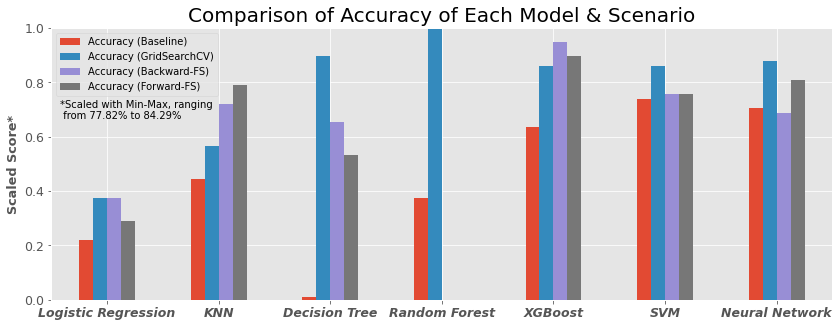

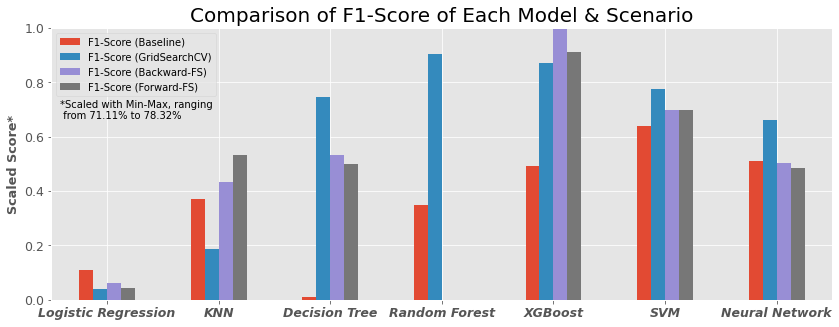

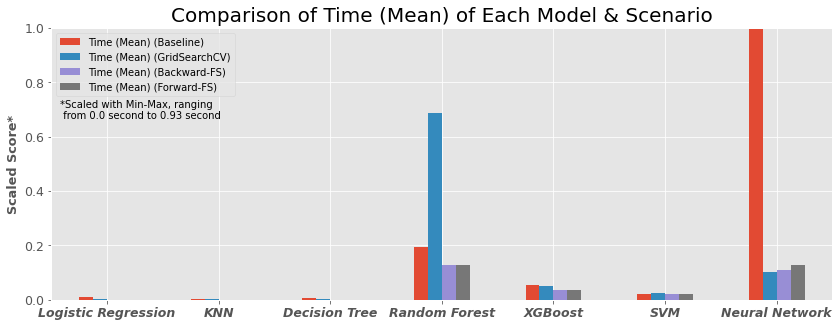

In [22]:
#@title Result Visualization for Each Metric

all_res_2 = res_baseline[['Model']].copy()

list_res = [res_baseline, res_gsc, res_fs, res_fs_fw]
list_metric_name = ['Accuracy', 'F1-Score', 'Time (Mean)']
list_desc =['Baseline', 'GridSearchCV', 'Backward-FS', 'Forward-FS']

for metric in list_metric_name:
  for res, desc in zip(list_res, list_desc):  
    all_res_2[metric+' ('+desc+')'] = res[[metric]].copy()
all_res_2.to_excel(my_path+'All Results_2.xlsx', index=False)

def plot_result(df, lower_idx, upper_idx, metric, unit='%'):  
  '''
  Function to visualize comparison of metric results. 
  In this function, scaling is done to make it easier 
  to see the difference in the results of each classifier, 
  because the difference in results among classifiers 
  is not too far away.
  '''
  max_metric = max(df[df.columns[lower_idx:upper_idx]].max())
  min_metric = min(df[df.columns[lower_idx:upper_idx]].min())*.999 #The lower bound is shifted by 0.1%, so that the lowest value can still be seen visually
  
  df_ = df.copy()
  df_[df_.columns[lower_idx:upper_idx]] = (df_[df_.columns[lower_idx:upper_idx]]-min_metric)/(max_metric-min_metric)

  plt.rcParams['ytick.labelsize'] = 12.5
  plt.style.use('ggplot')
  ax = df_[df_.columns[:upper_idx]].plot(kind='bar', ylim=(0,1), figsize=(14,5))
  ax.set_xticks(df_.index)
  ax.set_xticklabels(df_.Model, rotation=0, fontstyle='italic', fontweight='bold', fontsize=12.5)
  ax.set_title('Comparison of {} of Each Model & Scenario'.format(metric), fontsize=20)
  ax.set_ylabel('Scaled Score*', fontweight='bold', fontsize=12.75)
  ax.text(-.425,.665, '*Scaled with Min-Max, ranging\n from {}{} to {}{}'\
          .format(round(min_metric,2), unit, round(max_metric,2), unit))
  ax.legend(loc=2)

plot_result( all_res_2,1,5,'Accuracy' )
plot_result( all_res_2.drop(columns=all_res_2.columns[1:5]),
             1,5,'F1-Score' )
plot_result( all_res_2.drop(columns=all_res_2.columns[1:9]),
             1,5,'Time (Mean)', ' second' )

In [23]:
#@title Full Table (Ranked by Best Accuracy)
all_res.reset_index().drop('index', axis=1)

,Model,Desc,Accuracy,F1-Score,Time (Mean)
0,Random Forest,GridSearchCV,84.290377,77.628542,0.641300
1,XGBoost,Bacward-FS,83.953299,78.316432,0.036190
2,XGBoost,Forward-FS,83.616220,77.687514,0.035758
3,Decision Tree,GridSearchCV,83.614337,76.491676,0.003495
4,Neural Network,GridSearchCV,83.501350,75.869966,0.096287
5,XGBoost,GridSearchCV,83.392756,77.390787,0.047008
6,SVM,GridSearchCV,83.388990,76.702902,0.024854
7,Neural Network,Forward-FS,83.052539,74.613717,0.118791
8,KNN,Forward-FS,82.938924,74.936508,0.001157
9,SVM,Forward-FS,82.715460,76.153051,0.020569


In [24]:
#@title Full Table (Wide)
all_res_2

,Model,Accuracy (Baseline),Accuracy (GridSearchCV),Accuracy (Backward-FS),Accuracy (Forward-FS),F1-Score (Baseline),F1-Score (GridSearchCV),F1-Score (Backward-FS),F1-Score (Forward-FS),Time (Mean) (Baseline),Time (Mean) (GridSearchCV),Time (Mean) (Backward-FS),Time (Mean) (Forward-FS)
0,Logistic Regression,79.237336,80.248572,80.244178,79.685519,71.904388,71.403614,71.553187,71.430348,0.010873,0.004137,0.001607,0.001514
1,KNN,80.697382,81.482016,82.490114,82.938924,73.781543,72.459636,74.244870,74.936508,0.003287,0.003620,0.001108,0.001157
2,Decision Tree,77.894043,83.614337,82.044442,81.258553,71.180060,76.491676,74.951994,74.722043,0.006382,0.003495,0.001714,0.002027
3,Random Forest,80.249200,84.290377,NaN,NaN,73.618824,77.628542,NaN,NaN,0.183352,0.641300,0.120393,0.121185
4,XGBoost,81.932082,83.392756,83.953299,83.616220,74.659723,77.390787,78.316432,77.687514,0.053210,0.047008,0.036190,0.035758
5,SVM,82.603729,83.388990,82.715460,82.715460,75.726680,76.702902,76.153051,76.153051,0.022383,0.024854,0.021257,0.020569
6,Neural Network,82.382148,83.501350,82.271672,83.052539,74.796611,75.869966,74.737027,74.613717,0.932329,0.096287,0.104535,0.118791
